In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import tree
from IPython.display import Image
import pydotplus
import graphviz
%matplotlib inline

In [2]:
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()

# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Create training and test sets.
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]

# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X2 = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno', 'agea', 'happy', 'tvtot'])]

# Make the categorical variable 'country' into dummies.
X2 = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Create training and test sets.
offset = int(X2.shape[0] * 0.8)

# Put 80% of the data in the training set.
X2_train, y_train = X2[:offset], y[:offset]

# And put 20% in the test set.
X2_test, y_test = X2[offset:], y[offset:]

---

Gradient Boosting

Weak learner 0 R^2: -1.0776893982110556
Weak learner 20 R^2: -0.0011725917548572884
Weak learner 40 R^2: -0.001112405823435303
Weak learner 60 R^2: -0.0007061324494808119
Weak learner 80 R^2: -0.0007653306825132766
Weak learner 100 R^2: -0.0006833753349724248


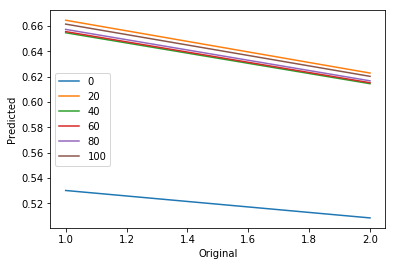

Overall R^2:
-0.24941664956939194


In [3]:
# Store values from loops.
preds = pd.DataFrame()
labels = []

uniquex = df['partner'].unique()

# Iterate through decision trees, each time using the residuals
# from the previous tree as the inputs.
for m in range(0, 101):
    
    # Initialize and fit the tree. Set the max depth to 2.
    decision_tree = tree.DecisionTreeRegressor(max_depth=2)
    decision_tree.fit(X,y)
    
    # Get and store predicted values.
    pred = decision_tree.predict(X)
    preds['pred{}'.format(m)] = pred
    
    # Residuals.
    y = y - pred

    # Output every 20 iterations.
    if m % 20 == 0:
        print('Weak learner {} R^2: {}'.format(m, decision_tree.score(X, y)))
        labels = labels + [m]
        bestpred = preds.sum(axis=1)
        plt.plot(uniquex, np.poly1d(np.polyfit(df['happy'], bestpred, 1))(uniquex))
       
plt.legend(labels)
plt.xlabel('Original')
plt.ylabel('Predicted')
plt.show()
predicted = preds.sum(axis=1)

print('Overall R^2:')
print(np.corrcoef(df['happy'], predicted)[0, 1])

In [4]:
# We will make 800 iterations, use 4-deep trees, and set our loss function. 
params = {'n_estimators': 800,
         'max_depth': 4,
         'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X2_train, y_train)

predict_train = clf.predict(X2_train)
predict_test = clf.predict(X2_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent Type I errors: 0.01258247659966242
Percent Type II errors: 0.08485499462943072

Test set accuracy:
Percent Type I errors: 0.0785276073619632
Percent Type II errors: 0.17668711656441718


In [5]:
# Set grid parameters
grid_params = {'n_estimators': [200, 500, 800, 1000],
         'max_depth': [2, 4, 6],}
# Use the grid
grid = GridSearchCV(clf, grid_params, cv=10, verbose=3)

#Fit the data
grid.fit(X2_train, y_train)

#return best parameters and best score for training model.
print('Best parameters for training model:')
print(grid.best_params_)
print('Best Score for training model:')
print(grid.best_score_)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
[CV] max_depth=2, n_estimators=200 ...................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....... max_depth=2, n_estimators=200, score=0.769, total=   1.0s
[CV] max_depth=2, n_estimators=200 ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] ....... max_depth=2, n_estimators=200, score=0.779, total=   1.1s
[CV] max_depth=2, n_estimators=200 ...................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s


[CV] ....... max_depth=2, n_estimators=200, score=0.744, total=   1.1s
[CV] max_depth=2, n_estimators=200 ...................................
[CV] ....... max_depth=2, n_estimators=200, score=0.715, total=   1.1s
[CV] max_depth=2, n_estimators=200 ...................................
[CV] ....... max_depth=2, n_estimators=200, score=0.718, total=   1.0s
[CV] max_depth=2, n_estimators=200 ...................................
[CV] ....... max_depth=2, n_estimators=200, score=0.782, total=   1.1s
[CV] max_depth=2, n_estimators=200 ...................................
[CV] ....... max_depth=2, n_estimators=200, score=0.782, total=   1.1s
[CV] max_depth=2, n_estimators=200 ...................................
[CV] ....... max_depth=2, n_estimators=200, score=0.733, total=   1.1s
[CV] max_depth=2, n_estimators=200 ...................................
[CV] ....... max_depth=2, n_estimators=200, score=0.739, total=   1.1s
[CV] max_depth=2, n_estimators=200 ...................................
[CV] .

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 20.0min finished


Best parameters for training model:
{'max_depth': 2, 'n_estimators': 200}
Best Score for training model:
0.7509590302286328


---

Neural Networks

In [6]:
# Import the model.

# Establish and fit the model, with a single, 100 perceptron layer.
mlp = MLPClassifier(hidden_layer_sizes=(100,))
mlp.fit(X2_train, y_train)

mlp.score(X2_train, y_train)

0.7575571582016265

In [7]:
cross_val_score(mlp, X2_train, y_train, cv=5)

array([0.74693252, 0.66257669, 0.75057559, 0.74597084, 0.75134305])

In [8]:
# Work on the test set.

# Let's see how the testing data performs.
mlp_pred = mlp.predict(X2_test)

confusion_matrix(y_test, mlp_pred)

array([[901, 100],
       [316, 313]], dtype=int64)

In [9]:
# Set parameters for mlp
mlp_params = [{'hidden_layer_sizes': [(100,4), (500,4), (1000,4)],
              'alpha': [.000001, .00001, .0001, .001, 1, 10],
              'max_iter': [200, 400, 600]}]

# Search for the best paramters. 
mlp_grid = GridSearchCV(mlp, mlp_params, cv=5, verbose=2, n_jobs=-1)

# Fit the grid and obtain results
mlp_grid.fit(X2_train, y_train)

# Return best parameters and best score
print('Best parameters:')
print(mlp_grid.best_params_)
print('Best Score:')
print(mlp_grid.best_score_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   39.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed: 13.3min finished


Best parameters:
{'alpha': 1, 'hidden_layer_sizes': (500, 4), 'max_iter': 400}
Best Score:
0.7442074574190578


In [14]:
mlp2 = MLPClassifier(hidden_layer_sizes=(500,4), max_iter=400)
mlp2.fit(X2_train, y_train)
mlp2.score(X2_train, y_train)

0.7715206383305202

In [19]:
cross_val_score(mlp2, X2_train, y_train, cv=5)

array([0.71932515, 0.47776074, 0.73215656, 0.61550269, 0.75134305])

In [22]:
mlp2_pred = mlp2.predict(X2_test)

confusion_matrix(y_test, mlp2_pred)

array([[954,  47],
       [360, 269]], dtype=int64)

In [18]:
mlp3 = MLPClassifier(hidden_layer_sizes=(1000,))
mlp3.fit(X2_train, y_train)

mlp3.score(X2_train, y_train)

0.7735154212060764

In [20]:
cross_val_score(mlp3, X2_train, y_train, cv=5)

array([0.74309816, 0.54371166, 0.74213354, 0.7237145 , 0.72985418])

In [23]:
mlp3_pred = mlp3.predict(X2_test)

confusion_matrix(y_test, mlp3_pred)

array([[970,  31],
       [392, 237]], dtype=int64)

In [17]:
mlp4 = MLPClassifier(hidden_layer_sizes=(10000,))
mlp4.fit(X2_train, y_train)
mlp4.score(X2_train, y_train)

0.757250268528464

In [21]:
cross_val_score(mlp4, X2_train, y_train, cv=5)

array([0.73082822, 0.55904908, 0.74366846, 0.73752878, 0.74443592])

In [24]:
mlp4_pred = mlp4.predict(X2_test)

confusion_matrix(y_test, mlp4_pred)

array([[891, 110],
       [317, 312]], dtype=int64)